In [80]:
import torch
from torch import nn
from torch.autograd.functional import jacobian
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

In [5]:
torch.set_default_dtype(torch.float64)

In [6]:
def derivative(y, x):
    dim = y.shape[-1]
    dydx = torch.zeros_like(y, dtype=y.dtype)
    for i in range(dim):
        yi = y[:,i].sum()
        dydx[:,i] = torch.autograd.grad(yi, x, create_graph=True, allow_unused=True)[0].squeeze()
    return dydx

## 1D Diffusion Equation

torch.Size([1024, 1]) torch.Size([1024, 1])


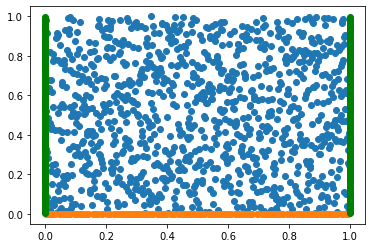

In [17]:
# Functions below specify the initial boundary value problem alongside its domain and analytic solution

def u0(x, L):
    return torch.sin(torch.pi/L * x)

def dirichlet_bc(x):
    return torch.zeros_like(x)

def pde(u,x,t):
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    
    return u_xx - u_t

def u_analytical(x, t, L):
    return np.sin(np.pi/L * x) *np.exp(-(torch.pi/L)**2 * t)

def spatio_temporal_sample(L, T, N_st, N_s, N_t):
    sampler = LatinHypercube(1)
    
    #Interior points
    samples_x = torch.tensor(L * sampler.random(n=N_st))
    samples_t = torch.tensor(T * sampler.random(n=N_st))
    
    # Spatial points at t=0 (initial conditions)
    samples_x_ic = torch.tensor(L * sampler.random(n=N_t))
    samples_t_ic = torch.zeros((N_t,1))
    
    # Temporal points at x=0,L (boundary conditions)
    samples_t_bc = torch.tensor(T * sampler.random(n=N_s))
    samples_x_bc = torch.zeros((N_s,1))
    samples_x_bc2 = L * torch.ones((N_s,1))
    
    return (samples_x, samples_t), (samples_x_ic, samples_t_ic), (samples_x_bc, samples_x_bc2, samples_t_bc)

(x, t), (x_ic, t_ic), (x_bc, x_bc2, t_bc) = spatio_temporal_sample(1, 1, 2**10, 2**7, 2**7)
print(x.shape, t.shape)
plt.scatter(x,t)
plt.scatter(x_ic,t_ic)
plt.scatter(x_bc,t_bc, c="green")
plt.scatter(x_bc2, t_bc, c="green")
plt.show()

## Definition of the Feedforward Net

In [20]:
class PiNN(nn.Module):
    def __init__(self, hidden_layers):
        super().__init__()

        prev_nodes_per_layer = 2;
        hidden = []
        for nodes_per_layer in hidden_layers:
            
            # Tanh is required as the PDE is second order in space and ReLU has a vanishing second derivative
            hidden += [nn.Linear(prev_nodes_per_layer, nodes_per_layer), nn.Tanh()]
            prev_nodes_per_layer = nodes_per_layer
        
        self.ff_relu_graph = nn.Sequential(*hidden)
            
        # Output Layer is assumed to be linear
        self.output = nn.Linear(prev_nodes_per_layer, 1)
        
    def forward(self, x, t): 
        return self.output(self.ff_relu_graph(torch.cat((x,t), 1)))

## Training of the Network

In [104]:
#IBVP parameters
L = 1
T = 1
    
# Hyperparameters for model and learning
verbose=True
hidden_layers = [20,20,20]
batchsize_interior= 2**10
batchsize_boundary= 2**9
batchsize_ic = 2**7
number_of_minibatches=1
epochs = 100
fixed_dataset = True

# Generate training set
(x_int, t_int), (x_init, t_init), (x_boundary, x_boundary2, t_bounary) = \
        spatio_temporal_sample(L, T, *(np.array([batchsize_interior, batchsize_boundary, batchsize_ic]*number_of_minibatches)))

# Generate test data
N_test = 2**10
(x_test,t_test) = spatio_temporal_sample(L, T, N_test, 1, 1)[0]
u_test = u_analytical(x_test, t_test, L)

net = PiNN(hidden_layers)
    
optimizer = torch.optim.LBFGS(net.parameters())
loss_fn = torch.nn.MSELoss()
    
if verbose:
    mse_train = []
    mse_test = []
    report_after_e_epochs = min(epochs, 10)
    
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f'{"Hyperparameters":-^70}')
    print(f'{"Network:":<40}')
    print(net)
    print(f'{"# of model parameters:":<40}{params:>30}\n')
    print(f'{"# of collocation points per batch:":<40}{batchsize_interior:>30}')
    print(f'{"# of boundary points per batch:":<40}{batchsize_boundary:>30}')
    print(f'{"# of initial condition points per batch:":<40}{batchsize_ic:>30}')
    print(f'{"# of minbatches:":<40}{number_of_minibatches:>30}')
    print(f'{"Points per Iteration:":<40}{batchsize_interior * batchsize_boundary * batchsize_ic * number_of_minibatches:>30}')
    print(f'{"Points fixed?:":<40}{fixed_dataset:>30}')
    print(f'{"Iterations:":<40}{epochs:>30}')
    print(f'{"Total number of collocation points":<40}{epochs * batchsize_interior * batchsize_boundary * batchsize_ic * number_of_minibatches:>30}')
    print(f'{"":-^70}')
    print(f'{"Epoch":^10}|{"Total Loss":^15}|{"Loss (PDE)":^15}|{"Loss (BC)":^15}|{"Loss (IC)":^15}')
        
for e in range(epochs+1):
    for minibatch in range(number_of_minibatches):

        x = x_int[minibatch*batchsize_interior:(minibatch+1)*batchsize_interior,:]
        t = t_int[minibatch*batchsize_interior:(minibatch+1)*batchsize_interior,:]
            
        x_ic = x_init[minibatch*batchsize_ic:(minibatch+1)*batchsize_ic,:]
        t_ic = t_init[minibatch*batchsize_ic:(minibatch+1)*batchsize_ic,:]
            
        x_bc_0 = x_boundary[minibatch*batchsize_boundary:(minibatch+1)*batchsize_boundary,:]
        x_bc_L = x_boundary2[minibatch*batchsize_boundary:(minibatch+1)*batchsize_boundary,:]
        t_bc = t_bounary[minibatch*batchsize_boundary:(minibatch+1)*batchsize_boundary,:]
            
        x.requires_grad_(True)
        t.requires_grad_(True)
        last_total_loss_in_step = 0
        last_interior_loss_in_step = 0
        last_bc_loss_in_step = 0
        last_ic_loss_in_step = 0
        def compute_loss():
            global last_loss_in_step, last_interior_loss_in_step, last_bc_loss_in_step, last_ic_loss_in_step # sue me!
            optimizer.zero_grad()
            
            # Interior
            u = net(x, t)
            mse_interior = loss_fn(pde(u,x,t), torch.zeros_like(u))
            
            # Boundary Condition
            u_bc_0 = net(x_bc_0, t_bc)
            u_bc_L = net(x_bc_L, t_bc)
            mse_boundary = loss_fn(u_bc_0, dirichlet_bc(x_bc_0)) + loss_fn(u_bc_L, dirichlet_bc(x_bc_L))
        
            # Initial conditions
            u_ic = net(x_ic, t_ic)
            mse_ic = loss_fn(u_ic, u0(x_ic, L))
        
            #Total Loss
            loss =  mse_interior + mse_boundary + mse_ic
            loss.backward()
            
            last_loss_in_step = loss.item()
            last_interior_loss_in_step = mse_interior.item()
            last_bc_loss_in_step = mse_boundary.item()
            last_ic_loss_in_step = mse_ic.item()
            return loss
            
        optimizer.step(compute_loss)
            
        if verbose:
            # Monitor training error
            mse_train.append(last_loss_in_step)
            
            #Monitor test error (turn autodiff for this)
            with torch.autograd.no_grad():
                mse_test.append(loss_fn(net(x_test, t_test), u_test))
            
    if verbose and e % report_after_e_epochs == 0:
        print(f'{e:^10}|{last_loss_in_step:>15.6e}|{last_interior_loss_in_step:>15.6e}|{last_bc_loss_in_step:>15.6e}|{last_ic_loss_in_step:>15.6e}')
    
if verbose:
    print(f'{"Iteration limit reached":-^70}')

---------------------------Hyperparameters----------------------------
Network:                                
PiNN(
  (ff_relu_graph): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
  )
  (output): Linear(in_features=20, out_features=1, bias=True)
)
# of model parameters:                                             921

# of collocation points per batch:                                1024
# of boundary points per batch:                                    512
# of initial condition points per batch:                           128
# of minbatches:                                                     1
Points per Iteration:                                         67108864
Points fixed?:                                                       1
Iterations:                                               

## Comparison between PiNN and Analytical Solution

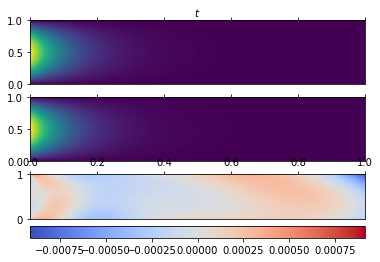

In [105]:
def dstack_product(x, y):
     return np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
    
N_t = 1000
N_x = 900
t = np.linspace(0, T, N_t)
x = np.linspace(0, L, N_x)
xx, tt = np.meshgrid(x,t)
u_ana = u_analytical(xx,tt, L)
xt = dstack_product(x,t)

with torch.autograd.no_grad():
    u_net = net(torch.from_numpy(xt[:,0].reshape(-1,1)),torch.from_numpy(xt[:,1]).reshape(-1,1))
u_net = u_net.reshape(N_t, N_x)

fig, ax = plt.subplots(nrows=3, sharex=True)

for a in ax:
    a.xaxis.tick_top()
    a.xaxis.set_label_position('top') 
for tk in ax[0].get_xticklabels():
    tk.set_visible(True)
for tk in ax[-1].get_xticklabels():
    tk.set_visible(True)
    
ax[0].pcolormesh(tt,xx,u_ana)
ax[1].pcolormesh(tt,xx,u_net)
im = ax[2].pcolormesh(tt, xx, u_net-u_ana,
                      cmap="coolwarm",
                      norm=colors.CenteredNorm())

divider = make_axes_locatable(ax[2])
cax = divider.new_vertical(size="25%", pad=0.1, pack_start=True)
fig.add_axes(cax)
cax.set_xlabel(r"$u_\text{analytical} - u_{net}$")
fig.colorbar(im, cax=cax, orientation="horizontal")

ax[0].set_xlabel(r"$t$")
plt.show()

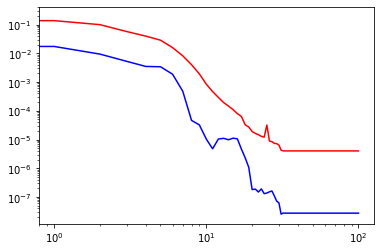

In [106]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
epoch = np.arange(epochs+1)
ax.plot(epoch, mse_train, color="red")
ax.plot(epoch, mse_test, color="blue")
plt.show()